## **ArcFace 실습에 필요한 파이썬 라이브러리를 불러옵니다.** 

In [1]:
from PIL import Image, ImageDraw
from IPython.display import display
import face_recognition
import numpy as np

import os
import math
import random
import time

import torch # pytorch의 tensor와 그와 관련된 기본 연산 등을 지원
import torch.nn as nn # 여러 딥러닝 layer와 loss, 함수 등을 클래스 형태로 지원
import torch.nn.functional as F # 여러 loss, 함수 등을 function 형태로 지원
import torch.optim as optim # 여러 optimizer를 지원

from torchvision.datasets import ImageFolder # (img, label) 형태의 데이터셋 구성을 쉽게 할 수 있도록 지원
import torchvision.transforms as T # 이미지 전처리를 지원
import torchvision.transforms.functional as TF
import torchvision.utils # 여러가지 편리한 기능을 지원 (ex. grid 이미지 만들기 등)
import torchvision.models as models # VGG, ResNet 등을 바로 로드할 수 있도록 지원
from torch.utils.data import DataLoader # 데이터 로더를 쉽게 만들 수 있도록 지원

from torch.utils.tensorboard import SummaryWriter # Tensorflow의 Tensorboard를 지원

# GPU 선택
os.environ['CUDA_VISIBLE_DEVICES']='1'

## Training에 사용될 데이터를 불러옵니다.
  
이번 실습에서 사용할 데이터셋은 __CASIA-Webface__ 데이터셋입니다.
  
  
- 총 ID 개수 : 10575  
- 총 이미지 개수 : 494414
- ID 당 최소 이미지 개수 : 2
- ID 당 최대 이미지 개수 : 804
- ID 당 평균 이미지 개수 : 46.75
- 이미지 크기 : 250 x 250

In [2]:
def data_loader(root, batch_size, resize, crop, gray_scale, shuffle):
    '''
    목적 : (image, label) 을 반복적으로 로드해주는 데이터 로더 만들기
    
    인자:
    root : 이미지의 루트 디렉토리
    batck_size : 배치 사이즈
    resize : 이미지 resize 사이즈
    crop : 이미지 crop 사이즈
    gray_scale : 흑백 변환 여부
    shuffle : 무작위 섞음 여부
    '''
    
    ''' Step 1. 이미지 전처리 '''
    trans_list = []
    
    if gray_scale:
        trans_list += [T.Grayscale(num_output_channels=1)]
        
    trans_list += [T.Resize((resize, resize)),
                   T.RandomCrop((crop, crop)),
                   T.ToTensor()]
    
    if gray_scale:
        trans_list += [T.Normalize(mean=(0.5,), std=(0.5,))]
    else:
        trans_list += [T.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))]
        
    # Compose에 원하는 전처리의 list를 전달한다.
    transformer = T.Compose(trans_list)
    
    ''' Step 2. Dataset 구성하기 '''
    # root - class directory - images 구조에서 (img, label) 꼴을 로드하는 데이터 로더의 구현에 사용 가능
    dataset = ImageFolder(root, transform=transformer)
    
    ''' Step 3. Data loader 만들기'''
    dloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
    
    # Tip : 여기서 data loader 뿐만 아니라 class의 개수, data 전체 개수를 같이 반환하면 나중에 편하다.
    return dloader, len(dataset.classes), len(dataset)

## 각 클래스의 데이터를 확인합니다.

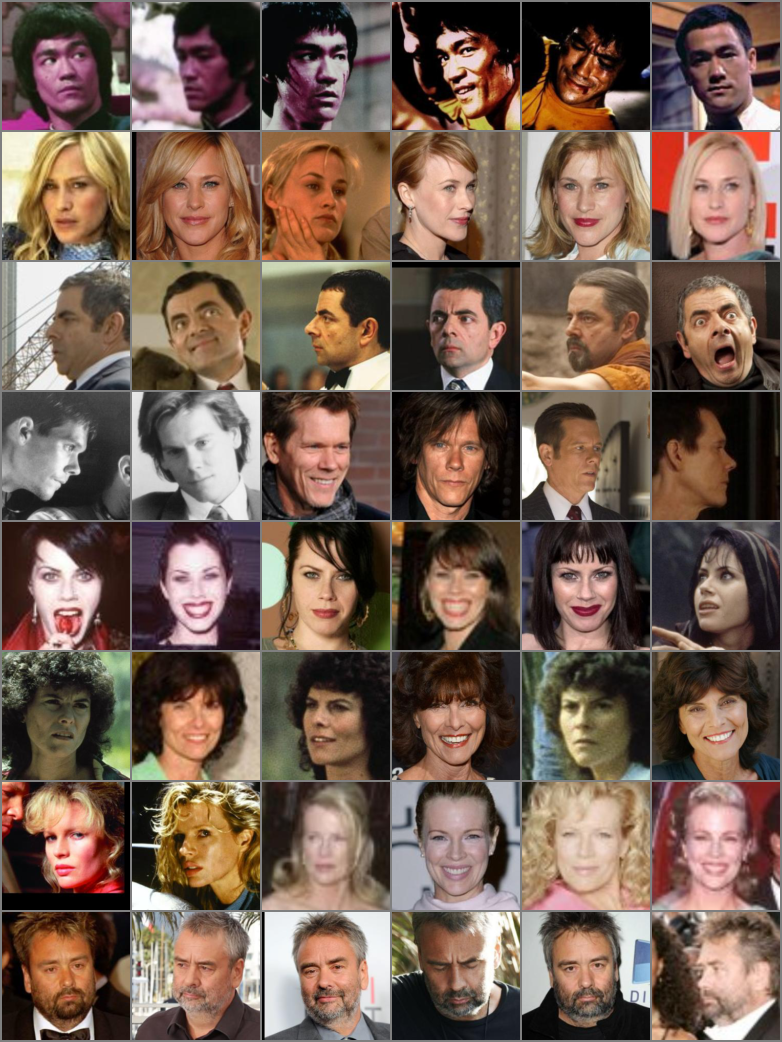

In [3]:
def visualize_data(trn_data_dir, img_per_class=6):    
    ''' 각 row에 같은 class의 이미지가 있는 이미지 만들기 '''
    temp_dloader, _, _ = data_loader(root=trn_data_dir, 
                                     batch_size=1024, 
                                     resize=128, 
                                     crop=128, 
                                     gray_scale=False,
                                     shuffle=False) # Shuffle을 하지 않았다. 클래스 순서대로 로드.
    
    # 한 번 load 할 때는 iter에 넣어서 사용 가능
    img, label = iter(temp_dloader).next()
    
    # 로드한 이미지들의 class 범위
    min_cls = torch.min(label)
    max_cls = torch.max(label)
    
    result_img = []
    
    for num_cls in range(min_cls, max_cls):
        # load한 이미지중 각 class의 첫 번째 이미지의 index를 찾아서 index ~ index + 6 까지의 이미지 저장
        first_idx = (label == num_cls).nonzero()[0]
        result_img.append(img[first_idx:first_idx + img_per_class])
        
    # list에 있는 이미지들을 묶어서 tensor로 변경
    result_img = torch.cat(result_img, dim=0)
    
    # tensor를 이미지로 변환
    grid_img = torchvision.utils.make_grid(result_img, nrow=img_per_class, padding=2)
    
    # denorm -> permute (PIL Image의 형태에 맞게) -> CPU로 전달
    ndarr = (((grid_img / 2) + 0.5) * 255).permute(1, 2, 0).to('cpu', torch.uint8).numpy()
    img = Image.fromarray(ndarr)
    return img

visualize_data(trn_data_dir='./data/CASIA-WebFace', img_per_class=6)

### ArcFace

![Architecture](img/arcface.PNG)
![Loss function](img/arc_loss.PNG)


## ArcFace의 모델을 구현합니다.
  
- Backbone model은 __ResNet-50__ 모델을 사용하도록 하겠습니다.
  
  
# 절차
1. ArcFace의 핵심에 해당하는 마지막 fc 의 class 구현
2. Pytorch에서 제공해주는 ResNet 을 불러와서 필요한 부분 변경하기
3. 1과 2에서 정의된 모듈을 사용하여 ArcFace network 구현

In [4]:
class ArcMarginProduct(nn.Module):
    '''
    목적 : Arc marin 을 포함한 last fc layer의 구현
    
    인자 :
    in_features : feature의 dimension
    out_features : class 개수
    '''
    def __init__(self, in_features, out_features, s=30.0, m=0.50, easy_margin=False):
        super(ArcMarginProduct, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.s = s
        self.m = m
        # fc의 parameter 만들기
        self.weight = torch.nn.Parameter(torch.FloatTensor(out_features, in_features))
        nn.init.xavier_uniform_(self.weight)

        self.easy_margin = easy_margin
        self.cos_m = math.cos(m)
        self.sin_m = math.sin(m)
        self.th = math.cos(math.pi - m)
        self.mm = math.sin(math.pi - m) * m

    def forward(self, input, label):
        '''
        Step 1. cos(theta + m) 계산하기
        '''
        # cosine : cos(theta)        
        # linear(x, W) = x * W^T = [N, in_features] * [in_features, out_features] = [N, out_features]
        # [N, out_features] / normalize-> cos dist == cos
        # F.normalize는 디폴트가 dim = 1 (줄이고자하는 dimension)
        cosine = F.linear(F.normalize(input), F.normalize(self.weight))
        
        # c^2 + s^2 = 1 
        sine = torch.sqrt((1.00000001 - torch.pow(cosine, 2)).clamp(0, 1))
        
        # cos(theta + m) = cos(theta) * cos(m) - sin(theta) * sin(m)
        phi = cosine * self.cos_m - sine * self.sin_m
        
        '''
        Step 2. cos(theta + m) 에서 dim=1에 대해 y_i에 해당하는 부분만 남기고 나머지는 cos(theta)로 되돌리기 
        '''
        one_hot = torch.zeros(cosine.size()).to(dev)
        one_hot.scatter_(1, label.view(-1, 1).long(), 1)
        
        output = (one_hot * phi) + ((1.0 - one_hot) * cosine)
        output *= self.s
        
        '''
        Step 3. 이 output이 softmax -> cross entropy loss로 흘러가면 된다.
        '''
        return output

class FeatureNet_50(nn.Module):
    '''
    목적 : ResNet-50을 이용한 backbone network(feature extractor) 구현 
    
    인자 :
    feature_dim : feature의 dimension
    gray_scale : 이미지를 gray scale로 받았는지 여부
    '''
    def __init__(self, feature_dim, gray_scale=True):
        super(FeatureNet_50, self).__init__()
        # Pytorch에서 이미 구현되어 있는 resnet-50 불러오기
        resnet = models.resnet50(pretrained=True)
        
        # 이런식으로 불러온 resnet을 조건에 맞게 변경할 수 있다.
        if gray_scale:
            resnet.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
            
        # resnet의 마지막 conv block까지만 남기고 나머지 부분 잘라내기
        self.backbone = nn.Sequential(* list(resnet.children())[0:-2])
        
        # resnet의 마지막 conv block 뒤쪽으로 새로 붙을 layer 들
        self.bn_4 = nn.BatchNorm2d(2048)
        self.dropout = nn.Dropout()
        self.fc = nn.Linear(2048 * 4 * 4, feature_dim)
        self.bn_5 = nn.BatchNorm1d(feature_dim)
        
    def forward(self, x):
        out = self.backbone(x)
        out = self.bn_4(out)
        out = self.dropout(out)
        
        # FC layer를 지나기 전에는 reshape 과정이 필요하다.
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        out = self.bn_5(out)
        return out

class ArcFaceNet(nn.Module):
    '''
    ArcMarginProduct와 FeatureNet-50 을 결합한 ArcFace 모델의 구현
    '''
    def __init__(self, feature_dim, cls_num, gray_scale=True):
        super(ArcFaceNet, self).__init__()
        self.feature_net = FeatureNet_50(feature_dim, gray_scale=gray_scale)
        self.classifier = ArcMarginProduct(feature_dim, cls_num)

    # 끝까지 Forward 하여 logit을 return
    def forward(self, x, label):
        out = self.feature_net(x)
        out = self.classifier(out, label)
        return out
    
    # Feature만 return
    def extract_feature(self, x):
        out = self.feature_net(x)
        return out


## 학습에 사용될 유틸리티 함수들을 구현합니다.

In [5]:
def cos_dist(x1, x2):
    '''
    목적 : 벡터 x1, x2 사이의 Cosine similary를 계산
    
    인자 :
    x1, x2 : 두 벡터
    '''
    return torch.sum(x1 * x2) / (torch.norm(x1) * torch.norm(x2))

def fixed_img_list(lfw_pair_text, test_num):
    '''
    목적 : 중간 테스트 때 계속 사용될 고정 test 이미지 리스트 생성
    
    인자:
    lfw_pair_text : pair가 만들어진 이미지 경로
    test_num : 테스트에 사용할 pair 개수
    '''
    f = open(lfw_pair_text, 'r')
    lines = []

    while True:
        line = f.readline()
        if not line:
            break
        lines.append(line)
    f.close()

    random.shuffle(lines)
    lines = lines[:test_num]
    return lines

def verification(net, pair_list, tst_data_dir, img_size, gray_scale=True):
    '''
    목적 : Face verification 테스트 수행
    
    인자:
    net : 네트워크
    pair_list : pair가 만들어진 이미지 경로의 리스트
    tst_data_dir : 테스트 이미지가 있는 루트 디렉토리
    img_size : 테스트에 사용할 이미지 사이즈
    gray_scale : 흑백으로 변환 여부
    '''
    
    '''
    STEP 1 : 주어진 이미지 pair에서 feature 를 뽑아 similarity, label 리스트 생성
    '''
    similarities = []
    labels = []

    # 이미지 전처리
    trans_list = []
    
    #if gray_scale:
    #    trans_list += [T.Grayscale(num_output_channels=1)]
        
    trans_list += [T.CenterCrop((178, 178)),
                   T.Resize((img_size, img_size)),
                   T.ToTensor()]
    
    if gray_scale:
        trans_list += [T.Normalize(mean=(0.5,), std=(0.5,))]
    else:
        trans_list += [T.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))]
    t = T.Compose(trans_list)

    # 주어진 모든 이미지 pair에 대해 similarity 계산
    net.eval()
    with torch.no_grad(): # Test 때 GPU를 사용할 경우 메모리 절약을 위해 torch.no_grad() 내에서 하는 것이 좋다.
        for idx, pair in enumerate(pair_list):
            # Read paired images
            path_1, path_2, label = pair.split(' ')
            img_1 = t(Image.open(os.path.join(tst_data_dir, path_1))).unsqueeze(dim=0).to(dev)
            img_2 = t(Image.open(os.path.join(tst_data_dir, path_2))).unsqueeze(dim=0).to(dev)
            imgs = torch.cat((img_1, img_2), dim=0)

            # Extract feature and save
            features = net.extract_feature(imgs).cpu()
            similarities.append(cos_dist(features[0], features[1]))
            labels.append(int(label))
            
    '''
    STEP 2 : similarity와 label로 verification accuracy 측정
    '''
    best_accr = 0.0
    best_th = 0.0

    # 각 similarity들이 threshold의 후보가 된다
    list_th = similarities
    
    # list -> tensor
    similarities = torch.stack(similarities, dim=0)
    labels = torch.ByteTensor(labels)

    # 각 threshold 후보에 대해 best accuracy를 측정
    for i, th in enumerate(list_th):
        pred = (similarities >= th)
        correct = (pred == labels)
        accr = torch.sum(correct).item() / correct.size(0)

        if accr > best_accr:
            best_accr = accr
            best_th = th.item()

    return best_accr, best_th

def tsne_visualization(net, tsne_writer, iters, tst_data_dir, img_size=128, cls_num=20, 
                       min_data_num=10, max_data_num=50):
    '''
    목적 : 만들어진 고차원 feature를 저차원(2, 3) feature로 변환하여 시각화
    
    인자 : 
    net : 네트워크
    tsne_writer : 텐서보드 writer 객체
    tst_data_dir : 테스트 이미지가 있는 루트 디렉토리
    img_size : 이미지 크기
    cls_num : 시각화에 사용할 클래스 개수
    min_data_num : 클래스 포함되어 있어야 할 최소 이미지 개수
    max_data_num : 클래스 포함되어 있어야 할 최대 이미지 개수
    '''
    
    # 보유한 모든 id 에 대해 최소, 최대 이미지 보유 개수를 만족하는 id중 cls_num개만 선정
    id_path_list = [os.path.join(tst_data_dir, id) for id in os.listdir(tst_data_dir)]
    random.shuffle(id_path_list)
    
    picked_paths = []
    for id_path in id_path_list:
        if len(os.listdir(id_path)) > min_data_num and len(os.listdir(id_path)) < max_data_num:
            picked_paths.append(id_path)          
    picked_paths = picked_paths[:cls_num]
    
    # 이미지 전처리
    t = T.Compose([T.Grayscale(num_output_channels=1),
               T.CenterCrop((178, 178)),
               T.Resize((img_size, img_size)),
               T.ToTensor(),
               T.Normalize(mean=(0.5,), std=(0.5,))])
    
    # 선정된 id들의 모든 이미지를 읽고 이미지에 대한 id를 함께 저장
    imgs = []
    labels = []
    for id, id_path in enumerate(picked_paths):
        for img_name in os.listdir(id_path):
            img_path = os.path.join(id_path, img_name)
            img = t(Image.open(img_path)).unsqueeze(dim=0)
            imgs.append(img)
            labels.append(id)
            
    # 모든 이미지들에 대한 feature 뽑기
    # features = (N, feature_dim) / labels = (N, )
    imgs = torch.cat(imgs, dim=0).to(dev)
    with torch.no_grad():
        features = net.extract_feature(imgs)
        
    # T-sne를 이용한 시각화
    tsne_writer.add_embedding(features, metadata=labels, global_step=iters)

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

import math
import numpy as np
from collections import OrderedDict
from PIL import Image, ImageDraw, ImageFont

from box_utils import nms, calibrate_box, get_image_boxes, convert_to_square, _preprocess

class Flatten(nn.Module):

    def __init__(self):
        super(Flatten, self).__init__()

    def forward(self, x):
        """
        Arguments:
            x: a float tensor with shape [batch_size, c, h, w].
        Returns:
            a float tensor with shape [batch_size, c*h*w].
        """

        # without this pretrained model isn't working
        x = x.transpose(3, 2).contiguous()

        return x.view(x.size(0), -1)

class PNet(nn.Module):
    def __init__(self):
        super(PNet, self).__init__()
        # suppose we have input with size HxW, then
        # after first layer: H - 2,
        # after pool: ceil((H - 2)/2),
        # after second conv: ceil((H - 2)/2) - 2,
        # after last conv: ceil((H - 2)/2) - 4,
        # and the same for W

        self.features = nn.Sequential(OrderedDict([
            ('conv1', nn.Conv2d(3, 10, 3, 1)),
            ('prelu1', nn.PReLU(10)),
            ('pool1', nn.MaxPool2d(2, 2, ceil_mode=True)),

            ('conv2', nn.Conv2d(10, 16, 3, 1)),
            ('prelu2', nn.PReLU(16)),

            ('conv3', nn.Conv2d(16, 32, 3, 1)),
            ('prelu3', nn.PReLU(32))
        ]))

        self.conv4_1 = nn.Conv2d(32, 2, 1, 1)
        self.conv4_2 = nn.Conv2d(32, 4, 1, 1)

        weights = np.load('weights/pnet.npy', allow_pickle=True)[()]
        for n, p in self.named_parameters():
            p.data = torch.FloatTensor(weights[n])

    def forward(self, x):
        """
        Arguments:
            x: a float tensor with shape [batch_size, 3, h, w].
        Returns:
            b: a float tensor with shape [batch_size, 4, h', w'].
            a: a float tensor with shape [batch_size, 2, h', w'].
        """
        x = self.features(x)
        a = self.conv4_1(x)
        b = self.conv4_2(x) # Bounding Box Regression
        a = F.softmax(a, dim=1) # Face Classification
        return b, a


class RNet(nn.Module):
    def __init__(self):
        super(RNet, self).__init__()
        self.features = nn.Sequential(OrderedDict([
            ('conv1', nn.Conv2d(3, 28, 3, 1)),
            ('prelu1', nn.PReLU(28)),
            ('pool1', nn.MaxPool2d(3, 2, ceil_mode=True)),

            ('conv2', nn.Conv2d(28, 48, 3, 1)),
            ('prelu2', nn.PReLU(48)),
            ('pool2', nn.MaxPool2d(3, 2, ceil_mode=True)),

            ('conv3', nn.Conv2d(48, 64, 2, 1)),
            ('prelu3', nn.PReLU(64)),

            ('flatten', Flatten()),
            ('conv4', nn.Linear(576, 128)),
            ('prelu4', nn.PReLU(128))
        ]))

        self.conv5_1 = nn.Linear(128, 2)
        self.conv5_2 = nn.Linear(128, 4)

        weights = np.load('weights/rnet.npy', allow_pickle=True)[()]
        for n, p in self.named_parameters():
            p.data = torch.FloatTensor(weights[n])

    def forward(self, x):
        """
        Arguments:
            x: a float tensor with shape [batch_size, 3, h, w].
        Returns:
            b: a float tensor with shape [batch_size, 4].
            a: a float tensor with shape [batch_size, 2].
        """
        x = self.features(x)
        a = self.conv5_1(x)
        b = self.conv5_2(x) # Bounding Box Regression
        a = F.softmax(a, dim=1) # Face Classification
        return b, a


class ONet(nn.Module):
    def __init__(self):
        super(ONet, self).__init__()

        self.features = nn.Sequential(OrderedDict([
            ('conv1', nn.Conv2d(3, 32, 3, 1)),
            ('prelu1', nn.PReLU(32)),
            ('pool1', nn.MaxPool2d(3, 2, ceil_mode=True)),

            ('conv2', nn.Conv2d(32, 64, 3, 1)),
            ('prelu2', nn.PReLU(64)),
            ('pool2', nn.MaxPool2d(3, 2, ceil_mode=True)),

            ('conv3', nn.Conv2d(64, 64, 3, 1)),
            ('prelu3', nn.PReLU(64)),
            ('pool3', nn.MaxPool2d(2, 2, ceil_mode=True)),

            ('conv4', nn.Conv2d(64, 128, 2, 1)),
            ('prelu4', nn.PReLU(128)),

            ('flatten', Flatten()),
            ('conv5', nn.Linear(1152, 256)),
            ('drop5', nn.Dropout(0.25)),
            ('prelu5', nn.PReLU(256)),
        ]))

        self.conv6_1 = nn.Linear(256, 2)
        self.conv6_2 = nn.Linear(256, 4)
        self.conv6_3 = nn.Linear(256, 10)

        weights = np.load('weights/onet.npy', allow_pickle=True)[()]
        for n, p in self.named_parameters():
            p.data = torch.FloatTensor(weights[n])

    def forward(self, x):
        """
        Arguments:
            x: a float tensor with shape [batch_size, 3, h, w].
        Returns:
            c: a float tensor with shape [batch_size, 10].
            b: a float tensor with shape [batch_size, 4].
            a: a float tensor with shape [batch_size, 2].
        """
        x = self.features(x)
        a = self.conv6_1(x)
        b = self.conv6_2(x) # Bounding Box Regression
        c = self.conv6_3(x) # Face Landmark Detection
        a = F.softmax(a, dim=1) # Face Classification
        return c, b, a


def run_first_stage(image, net, scale, threshold):
    """Run P-Net, generate bounding boxes, and do NMS.

    Arguments:
        image: an instance of PIL.Image.
        net: an instance of pytorch's nn.Module, P-Net.
        scale: a float number,
            scale width and height of the image by this number.
        threshold: a float number,
            threshold on the probability of a face when generating
            bounding boxes from predictions of the net.

    Returns:
        a float numpy array of shape [n_boxes, 9],
            bounding boxes with scores and offsets (4 + 1 + 4).
    """

    # scale the image and convert it to a float array
    width, height = image.size
    sw, sh = math.ceil(width*scale), math.ceil(height*scale)
    img = image.resize((int(sw), int(sh)), Image.BILINEAR)
    img = np.asarray(img, 'float32')

    with torch.no_grad():
        img = Variable(torch.FloatTensor(_preprocess(img)))
        if torch.cuda.is_available():
            img = img.cuda()
            net = net.cuda()
    output = net(img)
    probs = output[1].data.cpu().numpy()[0, 1, :, :]
    offsets = output[0].data.cpu().numpy()
    # probs: probability of a face at each sliding window
    # offsets: transformations to true bounding boxes

    boxes = _generate_bboxes(probs, offsets, scale, threshold)
    if len(boxes) == 0:
        return None

    keep = nms(boxes[:, 0:5], overlap_threshold=0.5)
    return boxes[keep]


def _generate_bboxes(probs, offsets, scale, threshold):
    """Generate bounding boxes at places
    where there is probably a face.

    Arguments:
        probs: a float numpy array of shape [n, m].
        offsets: a float numpy array of shape [1, 4, n, m].
        scale: a float number,
            width and height of the image were scaled by this number.
        threshold: a float number.

    Returns:
        a float numpy array of shape [n_boxes, 9]
    """

    # applying P-Net is equivalent, in some sense, to
    # moving 12x12 window with stride 2
    stride = 2
    cell_size = 12

    # indices of boxes where there is probably a face
    inds = np.where(probs > threshold)

    if inds[0].size == 0:
        return np.array([])

    # transformations of bounding boxes
    tx1, ty1, tx2, ty2 = [offsets[0, i, inds[0], inds[1]] for i in range(4)]
    # they are defined as:
    # w = x2 - x1 + 1
    # h = y2 - y1 + 1
    # x1_true = x1 + tx1*w
    # x2_true = x2 + tx2*w
    # y1_true = y1 + ty1*h
    # y2_true = y2 + ty2*h

    offsets = np.array([tx1, ty1, tx2, ty2])
    score = probs[inds[0], inds[1]]

    # P-Net is applied to scaled images
    # so we need to rescale bounding boxes back
    bounding_boxes = np.vstack([
        np.round((stride*inds[1] + 1.0)/scale),
        np.round((stride*inds[0] + 1.0)/scale),
        np.round((stride*inds[1] + 1.0 + cell_size)/scale),
        np.round((stride*inds[0] + 1.0 + cell_size)/scale),
        score, offsets
    ])
    # why one is added?

    return bounding_boxes.T


def detect_faces(image, min_face_size=20.0,
                 thresholds=[0.6, 0.7, 0.8],
                 nms_thresholds=[0.7, 0.7, 0.7]):
    """
    Arguments:
        image: an instance of PIL.Image.
        min_face_size: a float number.
        thresholds: a list of length 3.
        nms_thresholds: a list of length 3.

    Returns:
        two float numpy arrays of shapes [n_boxes, 4] and [n_boxes, 10],
        bounding boxes and facial landmarks.
    """

    # LOAD MODELS
    pnet = PNet()
    rnet = RNet()
    onet = ONet()
    onet.eval()

    # BUILD AN IMAGE PYRAMID
    width, height = image.size
    min_length = min(height, width)

    min_detection_size = 12
    factor = 0.707  # sqrt(0.5)

    # scales for scaling the image
    scales = []

    # scales the image so that
    # minimum size that we can detect equals to
    # minimum face size that we want to detect
    m = min_detection_size/min_face_size
    min_length *= m

    factor_count = 0
    # scales = [0.6, 0.42, 0.30, 0.21, 0.15, 0.10, 0.07, 0.05, 0.03]
    while min_length > min_detection_size:
        scales.append(m*factor**factor_count)
        min_length *= factor
        factor_count += 1

    # STAGE 1

    # it will be returned
    bounding_boxes = []

    # run P-Net on different scales
    for s in scales:
        boxes = run_first_stage(image, pnet, scale=s, threshold=thresholds[0])
        bounding_boxes.append(boxes)

    # collect boxes (and offsets, and scores) from different scales
    bounding_boxes = [i for i in bounding_boxes if i is not None]
    bounding_boxes = np.vstack(bounding_boxes)

    keep = nms(bounding_boxes[:, 0:5], nms_thresholds[0]) # NMS (Non-Maximum-Suppression)
    bounding_boxes = bounding_boxes[keep]

    # use offsets predicted by pnet to transform bounding boxes
    bounding_boxes = calibrate_box(bounding_boxes[:, 0:5], bounding_boxes[:, 5:])
    # shape [n_boxes, 5]

    bounding_boxes = convert_to_square(bounding_boxes)
    bounding_boxes[:, 0:4] = np.round(bounding_boxes[:, 0:4])

    # STAGE 2

    img_boxes = get_image_boxes(bounding_boxes, image, size=24)
    with torch.no_grad():
        img_boxes = Variable(torch.FloatTensor(img_boxes))
        if torch.cuda.is_available():
            rnet = rnet.cuda()
            img_boxes = img_boxes.cuda()
    output = rnet(img_boxes)
    offsets = output[0].data.cpu().numpy()  # shape [n_boxes, 4]
    probs = output[1].data.cpu().numpy()  # shape [n_boxes, 2]

    keep = np.where(probs[:, 1] > thresholds[1])[0]
    bounding_boxes = bounding_boxes[keep]
    bounding_boxes[:, 4] = probs[keep, 1].reshape((-1,))
    offsets = offsets[keep]

    keep = nms(bounding_boxes, nms_thresholds[1]) # NMS (Non-Maximum-Suppression)
    bounding_boxes = bounding_boxes[keep]
    bounding_boxes = calibrate_box(bounding_boxes, offsets[keep])
    bounding_boxes = convert_to_square(bounding_boxes)
    bounding_boxes[:, 0:4] = np.round(bounding_boxes[:, 0:4])

    # STAGE 3

    img_boxes = get_image_boxes(bounding_boxes, image, size=48)
    if len(img_boxes) == 0:
        return [], []
    with torch.no_grad():
        img_boxes = Variable(torch.FloatTensor(img_boxes))
        if torch.cuda.is_available():
            onet = onet.cuda()
            img_boxes = img_boxes.cuda()
    output = onet(img_boxes)
    landmarks = output[0].data.cpu().numpy()  # shape [n_boxes, 10]
    offsets = output[1].data.cpu().numpy()  # shape [n_boxes, 4]
    probs = output[2].data.cpu().numpy()  # shape [n_boxes, 2]

    keep = np.where(probs[:, 1] > thresholds[2])[0]
    bounding_boxes = bounding_boxes[keep]
    bounding_boxes[:, 4] = probs[keep, 1].reshape((-1,))
    offsets = offsets[keep]
    landmarks = landmarks[keep]

    # compute landmark points
    width = bounding_boxes[:, 2] - bounding_boxes[:, 0] + 1.0
    height = bounding_boxes[:, 3] - bounding_boxes[:, 1] + 1.0
    xmin, ymin = bounding_boxes[:, 0], bounding_boxes[:, 1]
    landmarks[:, 0:5] = np.expand_dims(xmin, 1) + np.expand_dims(width, 1)*landmarks[:, 0:5]
    landmarks[:, 5:10] = np.expand_dims(ymin, 1) + np.expand_dims(height, 1)*landmarks[:, 5:10]

    bounding_boxes = calibrate_box(bounding_boxes, offsets)
    keep = nms(bounding_boxes, nms_thresholds[2], mode='min') # NMS (Non-Maximum-Suppression)
    bounding_boxes = bounding_boxes[keep]
    landmarks = landmarks[keep]

    return bounding_boxes, landmarks


def show_bboxes(img, bounding_boxes, facial_landmarks=[]):
    """Draw bounding boxes and facial landmarks.

    Arguments:
        img: an instance of PIL.Image.
        bounding_boxes: a float numpy array of shape [n, 5].
        facial_landmarks: a float numpy array of shape [n, 10].

    Returns:
        an instance of PIL.Image.
    """

    img_copy = img.copy()
    draw = ImageDraw.Draw(img_copy)

    # Draw Bounding boxes
    for b in bounding_boxes:
        draw.rectangle([
            (b[0], b[1]), (b[2], b[3])
        ], outline='white')

    # Draw Facial Landmarks
    for p in facial_landmarks:
        for i in range(5):
            draw.ellipse([
                (p[i] - 1.0, p[i + 5] - 1.0),
                (p[i] + 1.0, p[i + 5] + 1.0)
            ], outline='blue')

    return img_copy


## 학습에 필요한 Hyperparameter 설정하기

In [7]:
# 각종 경로
trn_data_dir = './data/CASIA-WebFace'
tst_data_dir = './data/lfw'
lfw_pair_text = 'lfw_test_part.txt'
log_dir = 'log/arcface'
weight_dir = 'weight/arcface'

# 데이터 관련 세팅
batch_size = 16
resize = 128
crop = 128
gray_scale = True

# Hyperparameter
feature_dim = 512
lr = 0.1  # initial learning rate
lr_step = 10000
decay_ratio = 0.1
weight_decay = 5e-4

# Setting
max_epoch = 200
save_every = 10000
record_every = 1000
display_every = 1000
test_num = 6000

# GPU가 있을 경우 연산을 GPU에서 하고 없을 경우 CPU에서 진행
dev = 'cuda' if torch.cuda.is_available() else 'cpu'

# 디렉토리가 없을 시 생성
if not os.path.exists(weight_dir):
    os.makedirs(weight_dir)

## 학습에 필요한 객체들을 선언합니다.

In [8]:
# 데이터 로더
dloader, cls_num, data_num = data_loader(root=trn_data_dir,
                                         batch_size=batch_size,
                                         resize=resize,
                                         crop=crop,
                                         gray_scale=gray_scale,
                                         shuffle=True)
# 네트워크
net = ArcFaceNet(feature_dim=feature_dim, 
                 cls_num=cls_num, 
                 gray_scale=gray_scale).to(dev)

# optimizer 및 learning rate scheduler
optimizer = optim.SGD(net.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=lr_step, gamma=decay_ratio)

# loss function
criterion = nn.CrossEntropyLoss()

# log 기록
writer = SummaryWriter(log_dir)

## 학습을 시작합니다.

In [9]:
'''
# 현재 epoch와 현재까지의 전체 iteration
epoch = 0
total_iters = 0

# Best accuracy와 그 때의 iteration
best_accr = 0.0
best_iter = 0

# 중간 test에 사용할 고정 테스트 이미지 pair
fixed_test_pair = fixed_img_list(lfw_pair_text, test_num)

# 1 epoch 당 iterationㅇ,; 수
iter_per_epoch = (data_num // batch_size) + 1

# Training 시작
while(epoch < max_epoch):
    for iters, (img, label) in enumerate(dloader):
        # 매 iteration 마다 필요한 preprocess
        net.train()
        scheduler.step()
        optimizer.zero_grad()

        # 이미지, label을 로드하여 forward
        img, label = img.to(dev), label.to(dev)
        logit = net(img, label)
        loss = criterion(logit, label)

        # Bacpropagation 및 update
        loss.backward()
        optimizer.step()

        # 현재의 총 iteration 계산
        total_iters = (iter_per_epoch * epoch) + iters

        # 지금이 Record를 해야할 iteration일 경우
        if total_iters % record_every == 0:
            net.eval()
            
            # 중간 테스트
            accr, th = verification(net, fixed_test_pair, tst_data_dir, resize, gray_scale)

            # Tensorboard에 기록
            writer.add_scalar('loss', loss.item(), total_iters)
            writer.add_scalar('accr', accr, total_iters)
            writer.add_scalar('lr', scheduler.get_lr()[0], total_iters)
            
            # Best accuracy 체크
            if accr > best_accr:
                best_accr = accr
                best_iter = total_iters

        # 지금이 중간 결과를 보여줘야할 iteration일 경우
        if total_iters % display_every == 0:
            print(time.strftime("%Y-%m-%d %H:%M" + ":00"))
            print('* [Total iters : %d (epoch : %d / iter : %d)] => loss : %f, best_accr : %f(iter : %d)\n'\
                  %(total_iters, epoch, iters, loss.item(), best_accr, best_iter))

        # 지금이 모델을 저장해야할 iteration일 경우
        if total_iters % save_every == 0:
            file_name = 'ckpt_' + str(total_iters) + '.pkl'
            path_ckpt = os.path.join(weight_dir, file_name)
            torch.save(net.state_dict(), path_ckpt)

    # 모든 데이터를 다 돌면 epoch 증가
    epoch = epoch + 1
'''

'\n# \xed\x98\x84\xec\x9e\xac epoch\xec\x99\x80 \xed\x98\x84\xec\x9e\xac\xea\xb9\x8c\xec\xa7\x80\xec\x9d\x98 \xec\xa0\x84\xec\xb2\xb4 iteration\nepoch = 0\ntotal_iters = 0\n\n# Best accuracy\xec\x99\x80 \xea\xb7\xb8 \xeb\x95\x8c\xec\x9d\x98 iteration\nbest_accr = 0.0\nbest_iter = 0\n\n# \xec\xa4\x91\xea\xb0\x84 test\xec\x97\x90 \xec\x82\xac\xec\x9a\xa9\xed\x95\xa0 \xea\xb3\xa0\xec\xa0\x95 \xed\x85\x8c\xec\x8a\xa4\xed\x8a\xb8 \xec\x9d\xb4\xeb\xaf\xb8\xec\xa7\x80 pair\nfixed_test_pair = fixed_img_list(lfw_pair_text, test_num)\n\n# 1 epoch \xeb\x8b\xb9 iteration\xe3\x85\x87,; \xec\x88\x98\niter_per_epoch = (data_num // batch_size) + 1\n\n# Training \xec\x8b\x9c\xec\x9e\x91\nwhile(epoch < max_epoch):\n    for iters, (img, label) in enumerate(dloader):\n        # \xeb\xa7\xa4 iteration \xeb\xa7\x88\xeb\x8b\xa4 \xed\x95\x84\xec\x9a\x94\xed\x95\x9c preprocess\n        net.train()\n        scheduler.step()\n        optimizer.zero_grad()\n\n        # \xec\x9d\xb4\xeb\xaf\xb8\xec\xa7\x80, label\

In [10]:
# def cos_dist(x1, x2):
#     return torch.sum(x1 * x2) / (torch.norm(x1) * torch.norm(x2))

def face_similarity(features, test_feature):
    sum_ = torch.mm(features, torch.t(test_feature)).squeeze()
    norm = torch.norm(features, dim=1) * torch.norm(test_feature)
    return sum_ / norm

In [11]:
def detect_bound_box(image):
    face_recognition.face_locations(image)
    return null

In [12]:
def crop_image(image, bounding_box):
#     pil_image = Image.fromarray(image)
#     face_location = face_recognition.face_locations(image)
#     (bottom, right, top, left) = face_location[0]
#     cropped_image = pil_image.crop((left, bottom, right, top))
#     cropped_image=T.Resize((128, 128))(cropped_image)
#     #display(cropped_image)
#     cropped_image=T.Grayscale(num_output_channels=1)(cropped_image)
#     cropped_image=T.ToTensor()(cropped_image)
#     cropped_image=T.Normalize(mean=(0.5,), std=(0.5,))(cropped_image)

    left, top, right, bottom, _ = bounding_box.astype('int')
    cropped_image = TF.crop(image, top, left, bottom-top, right-left)
    
    cropped_image.show()

    trans_list = []        
    trans_list += [T.Grayscale(num_output_channels=1),
                   T.Resize((128, 128)),
                   T.ToTensor(),
                   T.Normalize(mean=(0.5,), std=(0.5,))]
    
    transformer = T.Compose(trans_list)
    
    cropped_image = transformer(cropped_image)
    
    return cropped_image.unsqueeze(0).to(dev)

('Learned feature for', 2, 'images.')
[786.20363648  53.21063769 937.38668919 257.07936633   0.99999988]
tensor([0.3791, 0.9011], device='cuda:0', grad_fn=<DivBackward0>)
[233.99788247  21.21526675 383.7901569  219.38422176   0.99999392]
tensor([0.4282, 0.7664], device='cuda:0', grad_fn=<DivBackward0>)


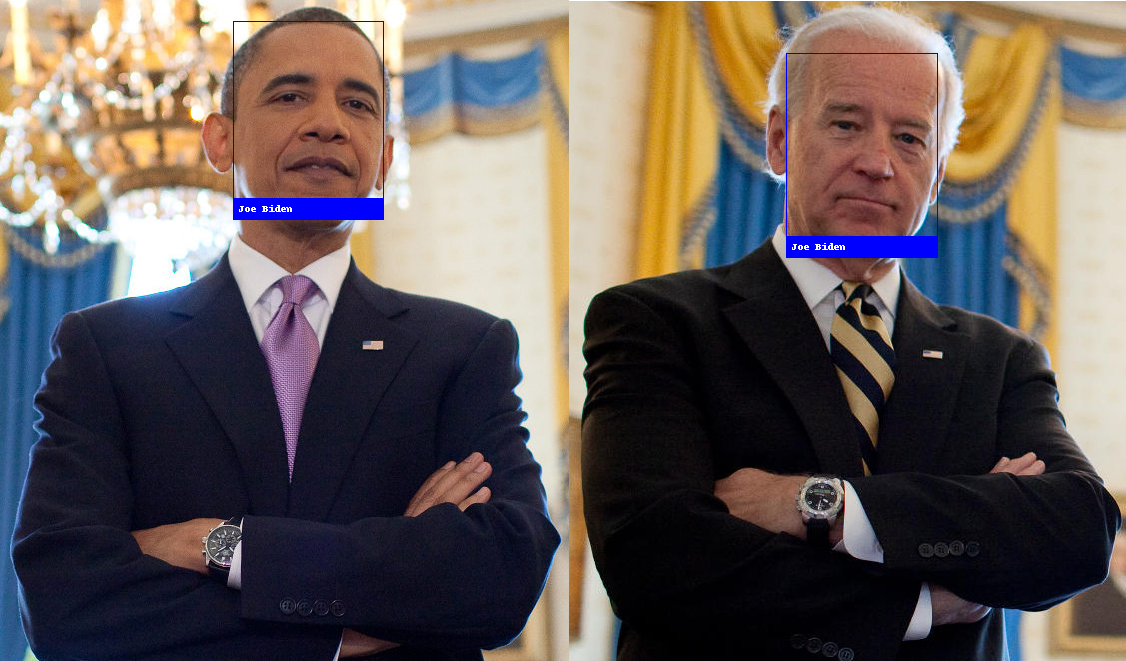

In [13]:
# fixed_test_pair = fixed_img_list(lfw_pair_text, test_num)

load_iters = 200000
ckpt_name = 'ckpt_' + str(load_iters) + '.pkl'
ckpt_path = os.path.join('weights/arcface_pretrained', ckpt_name)
net.load_state_dict(torch.load(ckpt_path))
net.eval()
torch.no_grad()
# This is an example of running face recognition on a single image
# and drawing a box around each person that was identified.
obama_image = Image.open('obama.jpg')
bounding_boxes, landmarks = detect_faces(obama_image)
obama_image_cropped = crop_image(obama_image, bounding_boxes[0])

biden_image = Image.open('biden.jpg')
bounding_boxes, landmarks = detect_faces(biden_image)
biden_image_cropped = crop_image(biden_image, bounding_boxes[0])

obama_face_feature = net.extract_feature(obama_image_cropped.to(dev))
biden_face_feature = net.extract_feature(biden_image_cropped.to(dev))

# Create arrays of known face encodings and their names
# known_face_features = [
#     obama_face_feature,
#     biden_face_feature
# ]
known_face_features = torch.cat((obama_face_feature, biden_face_feature))

known_face_names = [
    "Barack Obama",
    "Joe Biden"
]
print('Learned feature for', len(known_face_features), 'images.')

# Load an image with an unknown face
# unknown_image = face_recognition.load_image_file("two_people.jpg")
#unknown_image = face_recognition.load_image_file("obama_t1.jpg")
unknown_image = Image.open('two_people.jpg')
bounding_boxes, landmarks = detect_faces(unknown_image)

# pil_image = Image.fromarray(unknown_image)
# Find all the faces and face encodings in the unknown image
# face_locations = face_recognition.face_locations(unknown_image)

# Convert the image to a PIL-format image so that we can draw on top of it with the Pillow library
# See http://pillow.readthedocs.io/ for more about PIL/Pillow
# pil_image = Image.fromarray(unknown_image)
# Create a Pillow ImageDraw Draw instance to draw with
draw = ImageDraw.Draw(unknown_image)

# Loop through each face found in the unknown image
for box in bounding_boxes:
    
#     cropped_image = pil_image.crop((left, bottom, right, top))
#     display(cropped_image)
    
#     trans_list = []        
#     trans_list += [T.Grayscale(num_output_channels=1),
#                    T.Resize((128, 128)),
#                    T.ToTensor(),
#                    T.Normalize(mean=(0.5,), std=(0.5,))]
    
#     transformer = T.Compose(trans_list)
#     cropped_image = transformer(cropped_image)
#     cropped_image = cropped_image.unsqueeze(0).to(dev)
    
#     cropped_image = T.Resize((128, 128))(cropped_image)
#     display(cropped_image)
#     cropped_image = T.Grayscale(num_output_channels=1)(cropped_image)
#     cropped_image = T.ToTensor()(cropped_image)
#     cropped_image = cropped_image.unsqueeze(0).to(dev)

    cropped_image = crop_image(unknown_image, box)
    
    print(box)

    unknown_face_feature=net.extract_feature(cropped_image)

    # See if the face is a match for the known face(s)  
    #matches = compare_faces(known_face_features, unknown_face_feature)
    
    name = "Unknown"

    # Or instead, use the known face with the smallest distance to the new face
    distances = face_similarity(known_face_features, unknown_face_feature)
    print(distances)
    best_match_index = torch.argmax(distances)
    name = known_face_names[best_match_index]
    #if matches[best_match_index]:
    #    name = known_face_names[best_match_index]
    left, top, right, bottom, _ = box.astype('int')

    # Draw a box around the face using the Pillow module
    draw.rectangle(((left, top), (right, bottom)), outline=(0, 0, 255))

    # Draw a label with a name below the face
    text_width, text_height = draw.textsize(name)
    draw.rectangle(((left, bottom - text_height - 10), (right, bottom)), fill=(0, 0, 255), outline=(0, 0, 255))
    draw.text((left + 6, bottom - text_height - 5), name, fill=(255, 255, 255, 255))


# Remove the drawing library from memory as per the Pillow docs
del draw

# Display the resulting image
display(unknown_image)